In [14]:
from dolfin import *
from IPython.display import HTML
import matplotlib.pyplot as plt
import mshr as mh
import time
%matplotlib inline

La ecuación que trabajaremos será la ecuación del calor en medio isotrópico no homogéneo

$$u_t - \kappa(x)A(x)\nabla u = f_e(x)$$

Donde

* $u(x,t)$ es la temperatura

* $f_e(x)$ representa una fuente o fuentes de calor (estufas).

* $\kappa(x) = \dfrac{1}{\rho c_e}$ es la inversa (multiplicativa) del calor específico, multiplicado por la densidad, del medio en $x$. Se asumirá constante por pedazos (los medios que trabajaremos serán aire y paredes principalmente).

* $A(x)$ es la conductividad térmica del medio en $x$. Al asumir un medio isotrópico (cuya conductividad no depende de la dirección) es una matriz diagonal. También la asumimos constante por pedazos (de no serlo, ese término sería $\kappa(x) \sum_{i,j} \partial_{x_i} (A(x)\partial_{x_j}u)$)

Usaremos diferentes condiciones de borde. Podemos asumir, por ejemplo, condiciones de borde de tipo Dirichlet (temperatura exterior constante), condiciones de borde de tipo Neumann (para modelar el hecho de que hay temperatura que sale al exterior), o bien una condición mixta.


En primer lugar, se trabajará el problema 2-dimensional. Posteriormente se extenderá al caso 3-dimensional.

In [2]:
#### Caso 2D ####
'''
Los parámetros a definir serán:
la discretización temporal (número de pasos),
la temperatura exterior,
la temperatura y posición de la estufa,
las áreas que son paredes,
el calor específico y conductividad térmica de cada medio (aire, pared)
'''
#Parámetros
número_pasos = 100
temperatura_exterior = 0.
temperatura_estufa = 600.
x_estufa = 2/7 #posición de la estufa
y_estufa = 5/7
#String que, en C++, evalúa que un punto esté dentro de alguna pared (después probablemente lo haré con clases) 
en_paredes = "(x[0]<=1/7 || x[0]>= 6/7 || x[1]<=1/7 || x[1]>= 6/7)"
#Calores específicos, densidades y conductividades térmicas de ambos medios (pared y aire)
#(Los asumiremos constantes, en realidad cambian con la temperatura y presión: esto será importante en el caso 3D)
cal_esp_p = 0.88
rho_p = 2300 #asumimos pared de concreto
cond_p = 1.63

cal_esp_a = 1.01
rho_a = 1.24
cond_a = 0.02

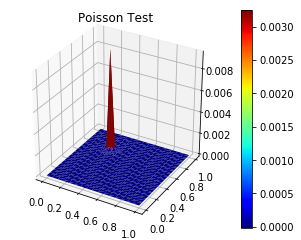

Tiempo: 0.01, solución guardada con norma L2 0.000244


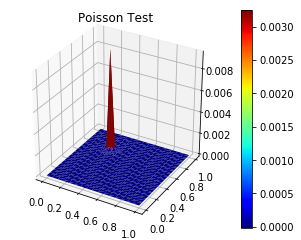

Tiempo: 0.21, solución guardada con norma L2 0.000244


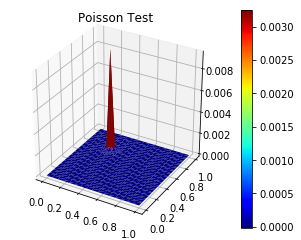

Tiempo: 0.41, solución guardada con norma L2 0.000244


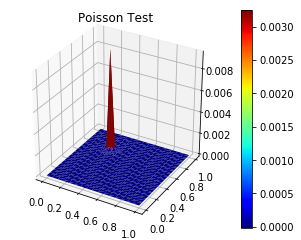

Tiempo: 0.61, solución guardada con norma L2 0.000244


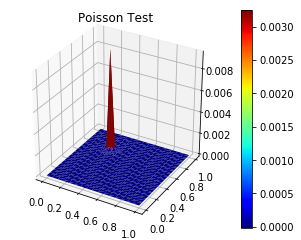

Tiempo: 0.81, solución guardada con norma L2 0.000244


In [44]:
#Esto no se toca, salvo para debuggear

# Parámetros temporales
T = 1 # Tiempo final
Δt = T / número_pasos # Paso de tiempo

# Crear malla y refinar cerca de la estufa
"""malla = UnitSquareMesh(16,16)
subdom = MeshFunction("bool", malla, 2)
subdom.set_all(False)
circulito = 'pow(x[0] - x_0, 2) + pow(x[1] - x_1, 2) <= pow(r, 2)'
subdomain = CompiledSubDomain(circulito, x_0 = x_estufa,x_1 = y_estufa,r = 0.1)
subdomain.mark(subdom, True)
malla = refine(malla, subdom)"""
# Espacio de funciones a considerar
V = FunctionSpace(malla,'Lagrange', 1)

##Funciones
#algunas variables auxiliares
eps = "0.02"
x_es_x_estufa = "("+str(x_estufa)+"- "+eps+" <=x[0] && x[0] <= "+str(x_estufa)+"+ "+eps+")"
y_es_y_estufa = "("+str(y_estufa)+"- "+eps+" <=x[1] && x[1] <= "+str(y_estufa)+"+ "+eps+")"
en_estufa = x_es_x_estufa+" && "+y_es_y_estufa
en_aire = "!"+en_paredes  #el aire es el espacio que queda

#Función de la fuente
f = Expression(str(temperatura_estufa)+"*"+en_estufa, degree=1)
#Función de conductividad térmica
A = Expression(str(cond_p)+"*"+en_paredes+" + "+str(cond_a)+"*"+en_aire, degree=1)
#Función de calor específico
k = Expression(str(1/(rho_p*cal_esp_p))+"*"+en_paredes+" + "+str(1/(rho_a*cal_esp_a))+"*"+en_aire, degree = 1)
# Condiciones de borde
#Definimos borde Dirichlet (por ahora, todo el borde)
cpp_borde = "(x[0] < DOLFIN_EPS || x[0] > 1. - DOLFIN_EPS || x[1] < DOLFIN_EPS || x[1] > 1. - DOLFIN_EPS) && on_boundary"
bc = DirichletBC(V, Constant(temperatura_exterior), cpp_borde)
#Borde Neumann (por ahora, cero)
#g = Expression("<<aquí expresión>>", degree = 1)

#Funciones para la formulación variacional
u, v = TrialFunction(V), TestFunction(V)
u_n = Function(V)

##Formulación variacional y sistema lineal
F = u*v*dx + Δt*k*A*inner(grad(u), grad(v))*dx - (u_n + Δt*f)*v*dx # - Δt*g*v*ds cuando haya Newmann
a, L = lhs(F), rhs(F)

# Preparación para guardar la solución
archivo_sol = File('Resultados/calor.pvd')
sols = []

# Iteración principal
u = Function(V)
u_n = interpolate(Constant(temperatura_exterior), V)

t = 0
for n in range(número_pasos):
    # Update-time
    t += Δt
    # Solve linear system
    solve(a == L, u, bc)
    
    # Save results
    archivo_sol << (u, t)
    
    if n % 20 == 0:
        fig = plt.figure()
        p = plot(u, title="Poisson Test", mode="warp")
        fig.colorbar(p)
        plt.show()
        print("Tiempo: {:.2f}, solución guardada con norma L2 {:4f}".format(t,norm(u, "L2")))
    # Update solution at time n and save to list for plotting
    u_n.assign(u)
    sols.append(u.copy(deepcopy=True))
#

In [41]:

HTML(X3DOM.html(malla))